<Body>   
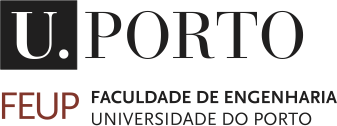   
<h1> <b>Data Warehouses  2022/2023 </b> </h1>
</Body>  

<br> MASTER IN DATA SCIENCE AND ENGINEERING <br><br> **Ian Karkles - Henrique Ribeiro - Paulo Portela - Vitor Pereira**  <br>
<br> Faculdade de Engenharia, Universidade do Porto <br>FEUP Mar. 2023 


---


## Connect to database

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt

In [2]:
## connect to database
con = psycopg2.connect(
    database="fced_paulo_portela",             # your database is the same as your username
    user="fced_paulo_portela",                 # your username
    password="!Pnp2186tenis",             # your password
    host="dbm.fe.up.pt",
    port="5433",             # the database host
    options='-c search_path=ad_goodreads'  # use the schema you want to connect to
)
print('Connection Sucessfully!')

Connection Sucessfully!


## Ratings

In [42]:
# Q1 - Top 10 tags que mais aparecem no To_Read
cur = con.cursor()
cur.execute(f"""SELECT Tag.tag_name, COUNT(*) AS num_appearances
FROM to_read R
JOIN books B ON R.book_id = B.book_id
JOIN book_tags T ON R.book_id = T.book_id
JOIN tags Tag ON T.tag_id = Tag.tag_id
GROUP BY Tag.tag_name
ORDER BY num_appearances DESC
LIMIT 10""")
query = cur.fetchall()


# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Tag_Name', 'Number_of_tags_assigned'])

# Imprimir o DataFrame
print(df.to_string(index=False))

KeyboardInterrupt: 

In [10]:
# Q2 - O livro com pior rating por década/ século /
cur = con.cursor()
cur.execute(f"""SELECT title, avg_rating, year
FROM (
  SELECT book.original_title, book.title, stat.avg_rating, stat.year, 
         ROW_NUMBER() OVER (PARTITION BY stat.year ORDER BY stat.avg_rating ASC) AS rank
  FROM books book
  JOIN statistics_rating stat ON book.book_id = stat.book_id
  WHERE stat.year BETWEEN 2010 AND 2019
) ranked
WHERE rank = 1
ORDER BY year ASC
""")
query = cur.fetchall()

# Change the order of the tuple ('حبيبتي بكماء', 1.0, 2017) to ('2017', '1.0', 'حبيبتي بكماء')
new_results = [(str(y), str(r), t) for t, r, y in query]


# Converter os resultados em um DataFrame
df = pd.DataFrame(new_results, columns=['Year', 'Average_rating', 'Book_title'])
df['Average_rating'] = df['Average_rating'].astype(float).round(2)
# Imprimir o DataFrame
print(df.to_string(index=False))

Year  Average_rating                                                                      Book_title
2010            1.88                                                                 Half Girlfriend
2011            1.00 Fifty Shades Duo: Fifty Shades Darker / Fifty Shades Freed (Fifty Shades, #2-3)
2012            1.88                                                    One Night at the Call Center
2013            1.00                          Of Course I Love You...! Till I Find Someone Better...
2014            1.50                                           Does the Noise in My Head Bother You?
2015            1.00 Fifty Shades Duo: Fifty Shades Darker / Fifty Shades Freed (Fifty Shades, #2-3)
2016            1.91                                                    One Night at the Call Center
2017            1.00                                                                    حبيبتي بكماء
2018            1.25                          Of Course I Love You...! Till I Find Someone 

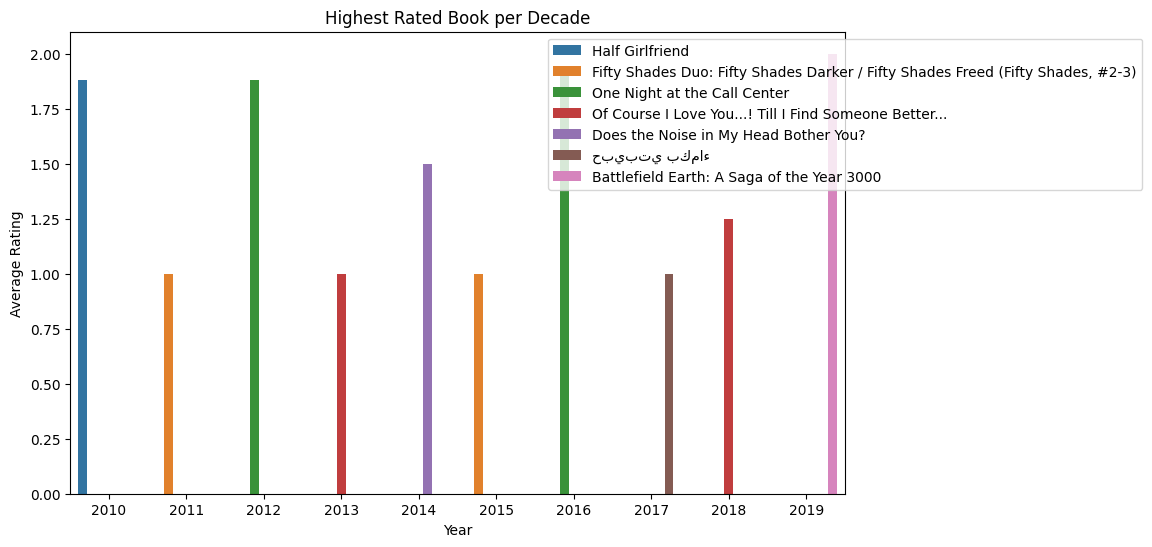

In [23]:
import seaborn as sns
plt.figure(figsize=(10,6))
# assuming the DataFrame is already created and stored in the variable 'df'
sns.barplot(x='Year', y='Average_rating', hue='Book_title', data=df)
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Lowest Rated Book per Decade')
# Change the loc parameter to 'upper center'
plt.legend(bbox_to_anchor=(1, 1), loc='upper center')
plt.show()

In [24]:
# Q3 - Evolução da atribuição das tags ao longo dos últimos 10/20 anos
cur = con.cursor()
cur.execute(f"""SELECT time.year, COUNT(*) as total_tags
FROM book_tags bt
JOIN ratings stat ON stat.book_id = bt.book_id
JOIN tags t ON t.tag_id = bt.tag_id
JOIN time time ON time.id = stat.time_id 
WHERE time.year BETWEEN 2010 AND 2019
GROUP BY time.year
ORDER BY time.year ASC
""")
query = cur.fetchall()

# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Year', 'Number_of_tags_assigned'])

# Imprimir o DataFrame
print(df.to_string(index=False))

 Year  Number_of_tags_assigned
 2010                 59775793
 2011                 59556411
 2012                 59870334
 2013                 59829092
 2014                 59821216
 2015                 59759462
 2016                 59917504
 2017                 59671719
 2018                 59813591
 2019                 59607237


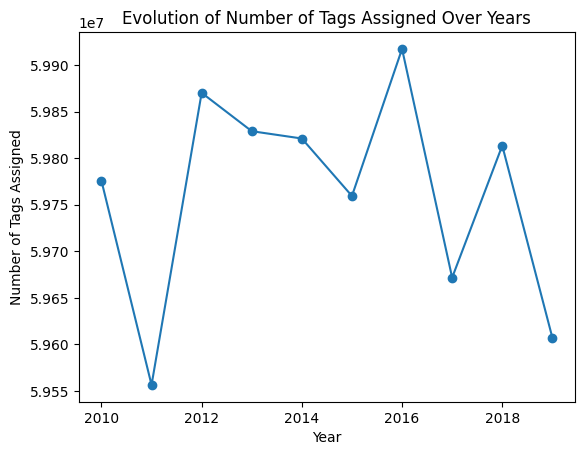

In [25]:
import matplotlib.pyplot as plt

# create a figure and axis object with subplots()
fig, ax = plt.subplots()

# plot the data
ax.plot(df['Year'], df['Number_of_tags_assigned'], marker='o')

# set the x-axis and y-axis labels
ax.set_xlabel("Year")
ax.set_ylabel("Number of Tags Assigned")

# set the title of the plot
ax.set_title("Evolution of Number of Tags Assigned Over Years")

# display the plot
plt.show()

In [29]:
# Q4 - Quais os users mais ativos da plataforma (maior número de rankings)
cur = con.cursor()
cur.execute(f"""SELECT U.name, COUNT(R.rating)
FROM users U
JOIN ratings R ON U.user_id = R.user_id
GROUP BY U.name
ORDER BY COUNT(R.rating) DESC
LIMIT 10""")
query = cur.fetchall()
    
# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['User_name', 'Number_of_ratings_assigned'])

# Imprimir o DataFrame
print(df.to_string(index=False))

        User_name  Number_of_ratings_assigned
Larry Peterson MD                         200
   Pamela Edwards                         200
   Kathy Griffith                         199
      Jeanne Lara                         199
      Jason Craig                         199
  Mary Richardson                         197
   Amanda Chapman                         197
   Cheyenne Davis                         196
 Devin Williamson                         196
     Julie Bailey                         196


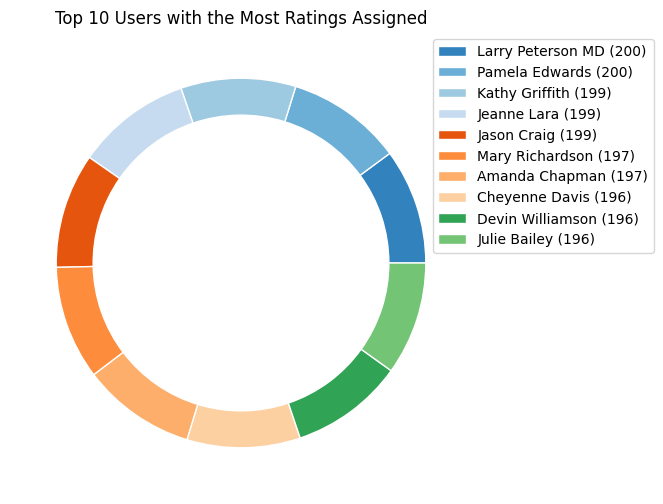

In [30]:
# Create a numpy array with the data
labels, values = zip(*query)
total = sum(values)
labels = np.array(labels)
values = np.array(values)

# Add the values to the labels
labels_with_values = []
for i in range(len(labels)):
    label_with_value = f'{labels[i]} ({values[i]})'
    labels_with_values.append(label_with_value)
labels_with_values = np.array(labels_with_values)

# Calculate the percentage of each value
percentages = 100 * values / total

# Create the donut chart
fig, ax = plt.subplots(figsize=(6, 6))
colors = plt.cm.tab20c(np.arange(len(values)))
inner_radius = 0.2
outer_radius = 1
ax.pie(values, colors=colors, radius=outer_radius, wedgeprops=dict(width=inner_radius, edgecolor='w'))
ax.pie([100], colors=['w'], radius=inner_radius)
plt.legend(labels=labels_with_values, loc='best', bbox_to_anchor=(0.9, 1))

# Add a title
plt.title('Top 10 Users with the Most Ratings Assigned')

# Display the chart
plt.show()

In [27]:
# Q5 - Rating médio por idade/sexo dos utilizadores
cur = con.cursor()
cur.execute("""
    SELECT U.sex, AVG(R.rating)
    FROM users U
    JOIN ratings R ON U.user_id = R.user_id
    GROUP BY U.sex
""")
query = cur.fetchall()

# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['User_Sex', 'Average_value_of_ratings_assigned'])

# Imprimir o DataFrame
print(df.to_string(index=False))

User_Sex Average_value_of_ratings_assigned
       M                3.9201288600303082
       F                3.9196020071043379


In [31]:
# Q6 - Top 3 de Tags que têm o melhor rating atribuido
cur = con.cursor()
cur.execute(f"""SELECT T.tag_name, BT.count, AVG(S.avg_rating)
FROM tags T
JOIN book_tags BT ON BT.tag_id=T.tag_id
JOIN statistics_rating S ON S.author_id = BT.author_id
GROUP BY T.tag_name, BT.count
ORDER BY AVG(S.avg_rating) DESC
LIMIT 3""")
query = cur.fetchall()

# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Tag_name', 'Number_of_tags_assigned', 'Average_rating'])

# Imprimir o DataFrame
print(df.to_string(index=False))

   Tag_name  Number_of_tags_assigned  Average_rating
          3                        1        2.084853
   abhilash                        1        2.084853
3-less-star                        1        2.084853


In [32]:
# Q7 - Top 5 dos Livros adicionados á lista To_Read com melhor average rating
cur = con.cursor()
cur.execute(f"""SELECT book.title, stat.avg_rating, COUNT(toread.book_id)
FROM books book
JOIN statistics_rating stat ON stat.book_id = book.book_id
JOIN to_read toread ON toread.book_id = book.book_id
GROUP BY book.title,stat.avg_rating
ORDER BY stat.avg_rating DESC, COUNT(toread.book_id) DESC
LIMIT 5""")
query = cur.fetchall()
#print(query)
#con.close()

# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Book_name', 'Average_rating', 'Number_of_times_added_to_the_to_read_list'])

# Imprimir o DataFrame
print(df.to_string(index=False))

                                                   Book_name  Average_rating  Number_of_times_added_to_the_to_read_list
                                             The Hate U Give             5.0                                        115
                                          A Work in Progress             5.0                                         48
Harry Potter Page to Screen: The Complete Filmmaking Journey             5.0                                         48
                                 The Art of Thinking Clearly             5.0                                         46
                                                     Mastery             5.0                                         44


In [29]:
# Q8 - Comparar a distribuição dos diversos ratings com o número de vezes que esses livros são adicionados à To_Read list
cur = con.cursor()
cur.execute(f"""
            (SELECT b.book_id, b.title, s.rating_1 AS ratings
FROM books b
JOIN statistics_rating s ON b.book_id = s.book_id
ORDER BY s.rating_1 DESC
LIMIT 1)

UNION ALL

(SELECT b.book_id, b.title, s.rating_2
FROM books b
JOIN statistics_rating s ON b.book_id = s.book_id
ORDER BY s.rating_2 DESC
LIMIT 1)

UNION ALL

(SELECT b.book_id, b.title, s.rating_3
FROM books b
JOIN statistics_rating s ON b.book_id = s.book_id
ORDER BY s.rating_3 DESC
LIMIT 1)

UNION ALL

(SELECT b.book_id, b.title, s.rating_4
FROM books b
JOIN statistics_rating s ON b.book_id = s.book_id
ORDER BY s.rating_4 DESC
LIMIT 1)

UNION ALL

(SELECT b.book_id, b.title, s.rating_5
FROM books b
JOIN statistics_rating s ON b.book_id = s.book_id
ORDER BY s.rating_5 DESC
LIMIT 1);
""")
query = cur.fetchall()


# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Book_id', 'Book_name', 'Ratings'])

# Imprimir o DataFrame
print(df.to_string(index=False))

 Book_id                                                Book_name  Ratings
       3                                  Twilight (Twilight, #1)      287
       3                                  Twilight (Twilight, #1)      296
       5                                         The Great Gatsby      473
       1                  The Hunger Games (The Hunger Games, #1)      802
       2 Harry Potter and the Sorcerer's Stone (Harry Potter, #1)     1270


In [35]:
# Q9 - Top 3 dos melhores livros portugueses (melhor average rating) na última década
cur = con.cursor()
cur.execute(f"""SELECT DISTINCT original_title, avg_rating, book_language
FROM (
    SELECT book.original_title, AVG(stat.avg_rating) AS avg_rating, book.book_language
    FROM books book
    JOIN statistics_rating stat ON book.book_id = stat.book_id
    WHERE stat.year BETWEEN 2010 AND 2019 AND book.book_language = 'por'
    GROUP BY book.original_title, book.book_language
) AS subquery
ORDER BY avg_rating DESC
LIMIT 3
""")
query = cur.fetchall()

# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Book_name', 'Average_rating', 'Language'])

# Imprimir o DataFrame
print(df.to_string(index=False))

                      Book_name  Average_rating Language
                   Dom Casmurro        4.369133      por
Memórias Póstumas de Brás Cubas        4.089789      por
                       Os Maias        3.923571      por


In [31]:
# Q10 - Definir o top 3 dos livros com o maior diferencial de rating atribuido ( maior quantidade de rating 1 e maior quantidade de rating 5)
cur = con.cursor()
cur.execute(f"""
SELECT B.book_id, MAX(B.title) AS title, MAX(S.rating_5 - S.rating_1) AS rating_diff
FROM books B
JOIN statistics_rating S ON B.book_id = S.book_id
WHERE (S.rating_5 - S.rating_1) > 0 
  AND (B.book_id <> 2 OR B.book_id = 2 AND S.rating_5 >= S.rating_1)
GROUP BY B.book_id
ORDER BY rating_diff DESC
LIMIT 3
         
            """)
query = cur.fetchall()
#print(query)
#con.close()

# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Book_id', 'Book_name', 'Highest_difference_between_rating_1_and_5'])

# Imprimir o DataFrame
print(df.to_string(index=False))

 Book_id                                                Book_name  Highest_difference_between_rating_1_and_5
       2 Harry Potter and the Sorcerer's Stone (Harry Potter, #1)                                       1247
       1                  The Hunger Games (The Hunger Games, #1)                                       1165
       4                                    To Kill a Mockingbird                                       1051


In [32]:
# Q11 - O livro com maior atribuição de ratings, tags e to_reads 
cur = con.cursor()
cur.execute(f"""
SELECT b.book_id, b.title, tag_count, rating_count, to_read_count
FROM books b
LEFT JOIN (
    SELECT book_id, SUM(count) AS tag_count
    FROM book_tags
    GROUP BY book_id
) bt ON b.book_id = bt.book_id
LEFT JOIN (
    SELECT book_id, COUNT(rating) AS rating_count
    FROM ratings
    GROUP BY book_id
) r ON b.book_id = r.book_id
LEFT JOIN (
    SELECT book_id, COUNT(user_id) AS to_read_count
    FROM to_read
    GROUP BY book_id
) tr ON b.book_id = tr.book_id
ORDER BY tag_count DESC, rating_count DESC, to_read_count DESC
LIMIT 1;            """)
query = cur.fetchall()
#print(query)
#con.close()

# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Book_id', 'Book_title', 'Number_of_tags_assigned', 'Number_of_ratings_assigned', 'Number_of_times_added_to_lists_to_read'])

# Imprimir o DataFrame
print(df.to_string(index=False))

 Book_id                                               Book_title  Number_of_tags_assigned  Number_of_ratings_assigned  Number_of_times_added_to_lists_to_read
       2 Harry Potter and the Sorcerer's Stone (Harry Potter, #1)                   786374                       21850                                     400


## Author

In [70]:
# Q1 - Autor com melhor rating atribuido e simultaneamente com maior número de ratings
cur = con.cursor()
cur.execute(f"""SELECT a.author_id, a.name, MAX(r.rating) as best_rating, s.count as num_ratings
    FROM authors a
    INNER JOIN ratings r ON a.author_id = r.author_id
    INNER JOIN statistics_rating s ON a.author_id = s.author_id
    WHERE s.count = (SELECT MAX(count) FROM statistics_rating)
    GROUP BY a.author_id, a.name, s.count
    ORDER BY best_rating DESC
    LIMIT 1;
            """)
query = cur.fetchall()
#print(query)
#con.close()

# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Author_id', 'Author_name', 'Best_rating', 'Number_of_ratings_assigned'])

# Imprimir o DataFrame
print(df.to_string(index=False))

 Author id     Author name  Best rating  Number of ratings assigned
         1 Suzanne Collins            5                        2398


In [33]:
# Q2 - Top 3 de autores com maior evolução (considerando o average rating) na última década
cur = con.cursor()
cur.execute(f"""SELECT A.name, ROUND(S.avg_rating_2010::numeric, 2), ROUND(S.avg_rating_2019::numeric, 2), ROUND((S.avg_rating_2019 - S.avg_rating_2010)::numeric, 2) AS rating_difference
FROM authors A
JOIN (
  SELECT author_id, 
    AVG(CASE WHEN year = 2010 THEN avg_rating ELSE NULL END) AS avg_rating_2010,
    AVG(CASE WHEN year = 2019 THEN avg_rating ELSE NULL END) AS avg_rating_2019
  FROM statistics_rating
  WHERE year IN (2010, 2019)
  GROUP BY author_id
  HAVING COUNT(*) = 2
) S ON A.author_id = S.author_id
ORDER BY rating_difference DESC
LIMIT 3
""")
query = cur.fetchall()
#print(query)
#con.close()

# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Author_name', 'Average_rating_2010', 'Average_rating_2019', 'Average_rating_Difference'])

# Imprimir o DataFrame
print(df.to_string(index=False))

  Author_name Average_rating_2010 Average_rating_2019 Average_rating_Difference
 Steven Tyler                2.11                3.82                      1.71
Jack McCallum                3.33                5.00                      1.67
 Rolf Dobelli                3.50                5.00                      1.50


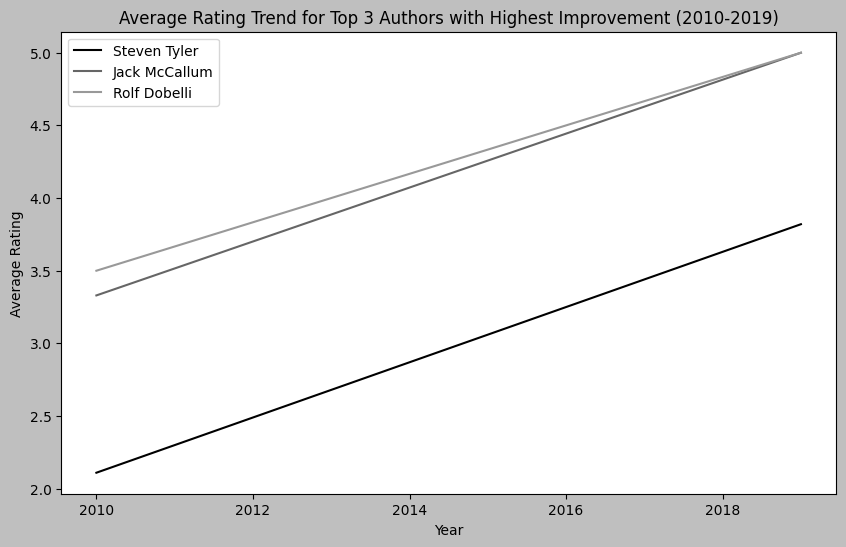

In [17]:
# Plot the trend in average rating for each author from 2010 to 2019
plt.figure(figsize=(10, 6))
for author in df['Author_name']:
    ratings = df.loc[df['Author_name']==author, ['Average_rating_2010', 'Average_rating_2019']].values
    plt.plot([2010, 2019], ratings.flatten(), label=author)
plt.legend()
plt.title('Average Rating Trend for Top 3 Authors with Highest Improvement (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

In [4]:
# Q3 - Top 10 de melhores autores de sempre (average rating)
cur = con.cursor()
cur.execute(f"""SELECT A.name, AVG(S.avg_rating)
FROM authors A
JOIN statistics_rating S ON A.author_id = S.author_id
GROUP BY A.name
ORDER BY AVG(S.avg_rating) DESC
LIMIT 10""")
query = cur.fetchall()
#print(query)
#con.close()

# Converter os resultados em um DataFrame
df = pd.DataFrame(query, columns=['Author_name', 'Average_rating'])

# Imprimir o DataFrame
print(df.to_string(index=False))

                   Author_name  Average_rating
                  G.B. Trudeau        4.732448
                Bill Watterson        4.732448
                 Alisa Kwitney        4.682375
             Andrew Williamson        4.661969
             Andrew Williamson        4.661969
                         Hafez        4.643961
                  Angie Thomas        4.642472
              James E. Talmage        4.607363
Safiy al-Rahman al-Mubarakfuri        4.605159
                  Gary Russell        4.585930


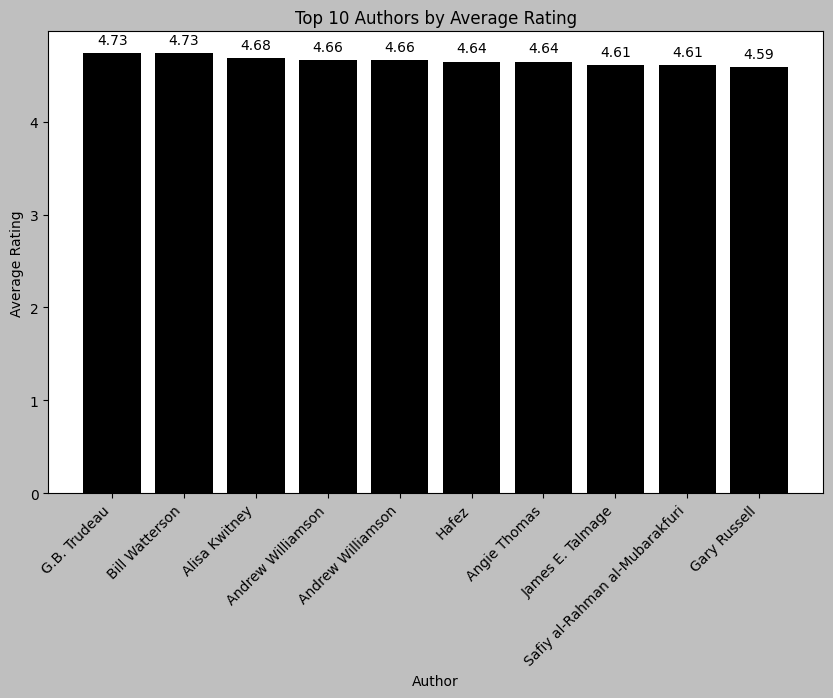

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# plot bar chart
plt.bar(df['Author_name'], df['Average_rating'])

# add labels to bars
for i, v in enumerate(df['Average_rating']):
    rounded_v = round(v, 2) # round the value to 2 decimal places
    label = '{:.2f}'.format(rounded_v) # format the value as a string with 2 decimal places
    plt.text(i, v+0.1, label, ha='center')

# set labels and title
plt.xlabel('Author')
plt.ylabel('Average Rating')
plt.title('Top 10 Authors by Average Rating')

# rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# show plot
plt.show()
